In [1]:
import numpy as np
import random


Model created, Proceeding to Optimisation with GA.

Optimal [Order Quantity, Reorder point] & Estimated Cycle Inventory level will be printed below...

 The best solution found:                                                                           
 [ 5.74608247 24.73926851]

 Objective function:
 10.513277938855564


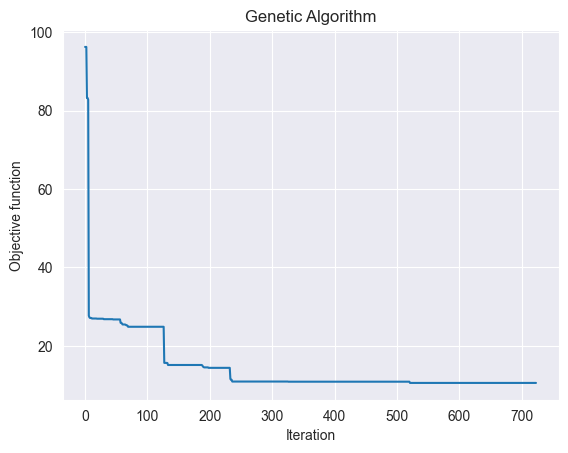

In [2]:
days = int(input("For how many days do you want to run this Simulation: "))

demand_mean = float(input("What is the Average daily Demand: "))
demand_sd = float(input("What is the Standard deviation of daily Demand: "))
lead_time_max = int(input("What is the Maximum lead time in days: "))
lead_time_min = int(input("What is the Minimum lead time in days: "))

asl = float(input("What is the required service level (e.g. 95.0) : "))

kk =0

if not 0<asl<100: #data validation on ASL
    while kk == 0:
        print("required service level has to be between 0 to 100")
        asl = float(input("What is the required service level (e.g. 95.0) : "))
        if not 0<asl<100:
            kk=0
        else:
            kk=1


days = days + 2*lead_time_max      # adding extra days to stabilise the simulation
days2 = days*2

def stoch_inv_sim(X): #Stochastic model defined as a function called stoch_inv_sim([Order qty, Reorder point])

    obj =0      #objective function for Genetic algorithm

    for k in range(10):  #Every strategy will be tested for 10 times since we are generating demand using random function,to be more exhaustive, you can increase the number to a higher value.
        tot_demand =0
        tot_sales=0

        a = [max(0,np.random.normal(demand_mean,demand_sd,1)) for i in range(days)] #Generating a random Demand
        stkout_count = 0
        inv =[]                 # array to store daily inventory
        pip_inv=[]

        in_qty = [0 for i in range(days2)]     #array indicating receipt of goods
        order_qty = X[0]
        reorder_pt = X[1]


        for i in range(days):

            if i == 0:
                beg_inv = reorder_pt            #day 0 assigning reorder point as begining inventory
                in_inv = 0
                stock_open = beg_inv + in_inv
            else:
                beg_inv = end_inv
                in_inv = in_qty[i]              #incoming inventory on i'th day
                stock_open = beg_inv + in_inv

            demand = a[i]                     #calling demand of i'th day from demand array a

            lead_time = random.randint(lead_time_min,lead_time_max)    #lead time of replenishment

            if demand < stock_open:
                end_inv = stock_open - demand     #formula to calculate ending inventory
            else:
                end_inv = 0
            inv.append(0.5*stock_open+0.5*end_inv)     #storing the average of opening stock and ending inventory as cycle inventory



            if i==0:
                pipeline_inv = 0
            else:
                pipeline_inv = sum(in_qty[j] for j in (i+1,days2-1))   #calculating the piepline inventory as on i'th day

            if pipeline_inv + end_inv <= reorder_pt:
                if i+lead_time <days:
                    in_qty[i+lead_time] = in_qty[i+lead_time]+order_qty   #ordering new stock and adding to the incoming inventory list

            if i>=2*lead_time_max:                            #the start of simulation performance monitoring
                tot_sales = tot_sales + stock_open - end_inv  #total sales during the simulation length
                tot_demand = tot_demand + demand              #total demand during the simulation length


        cycle_inv = 0
        for n in range(len(inv)):
            cycle_inv = cycle_inv + inv[n]              #calculating the averge cycle inventory
        cycle_inv = cycle_inv/len(inv)

        if tot_sales*100/(tot_demand+0.000001) <asl:
            aa = cycle_inv+10000000*demand_mean*(tot_demand-tot_sales)  #Imposing a penatly when ASL is not met the requirement
        else:
            aa = cycle_inv

        obj = obj + aa      #objective function i.e. cycle inventory calculation

    return obj/10

print()
print("Model created, Proceeding to Optimisation with GA.")
print()
print("Optimal [Order Quantity, Reorder point] & Estimated Cycle Inventory level will be printed below...")
print()

#Below is the gentic Algorithm code

from geneticalgorithm import geneticalgorithm as ga

varbound=np.array([[0,demand_mean*lead_time_max*5]]*2)

algorithm_param = {'max_num_iteration': 1000,
                   'population_size':15,
                   'mutation_probability':0.1,
                   'elit_ratio': 0.01,
                   'crossover_probability': 0.5,
                   'parents_portion': 0.3,
                   'crossover_type':'uniform',
                   'max_iteration_without_improv':200}

model=ga(function=stoch_inv_sim,dimension=2,variable_type='real',variable_boundaries=varbound,algorithm_parameters=algorithm_param)

model.run()